In [ ]:
#Importante instalar estas librerias con estas versiones, solo ejecuten este pedazo de codigo y esperen
!pip install tensorflow==1.15
!pip install keras==2.3.0
!pip install h5py==2.10.0 --force-reinstall

In [6]:
# Conectamos nuestro google drive con google colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Aqui nos ubicamos en la dirección del proyecto
import sys
sys.path.insert(0,'/content/drive/MyDrive/RCNN_Gun')

In [ ]:
#Importamos librerias
import os
import json
import datetime
import numpy as np
import skimage.draw
import cv2
from mrcnn.visualize import display_instances
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Directorio del proyecto
ROOT_DIR = "/content/drive/MyDrive/RCNN_Gun"
# Importamos el MASK R-CNN
sys.path.append(ROOT_DIR)
from mrcnn.config import Config
from mrcnn import model as modellib, utils

# Entrenamos con los pesos de las neuronas, usando "mask_rcnn_coco.h5" el cual nos ayudara a crear nuestro propio modelo
COCO_WEIGHTS_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

# Directorio donde guardaremos los logs, que es la carpeta donde tendra nuestro modelo posteriormente, el cual generara un documento ********.h5, como el "mask_rcnn_coco.h5" el que vimos arriba
DEFAULT_LOGS_DIR = os.path.join(ROOT_DIR, "logs")



class CustomConfig(Config):
    """Configuration for training on the custom  dataset.
    Derives from the base Config class and overrides some values.
    """
    # Puedes darle realmente cualquiero nombrre aqui y cambiar "object" por el que quieras
    NAME = "object"

    # Dependiendo de tu GPU puedes subir este valor, si no, dejalo en 1
    IMAGES_PER_GPU = 1

    # Aqui identificaremos el numero de clases, por ejemplo en este proyecto tenemos, el fondo, y el arma, pero puedes agregar la cantidad que quieras
    # podrias poner NUM_CLASSES = 2 y es lo mismo que abajo
    # Si tienes mas clases ademas del fondo y el arma, podrias hacer lo siguiente:
    # NUM_CLASSES = 1 + 2, donde ese dos son tus clases como decir , Fondo + botella + lapiz
    NUM_CLASSES = 1 + 1  # Fondo + Arma

    # Numero de epocas para entrenar el modelo, en el ultimo bloque de train(model), cuando vayas a ejecutarlo, vas a ver que al final de que carga la barra...
    # dice loss y val_loss, estos van variando, pero la idea es que sean los mas bajos posibles, asi que modifica el SETPS_PER_EPOCH = 40 por otro numero que te de mejores valores al final
    STEPS_PER_EPOCH = 40

    # Saltar la detección si no consigue un 90% para arriba 
    DETECTION_MIN_CONFIDENCE = 0.9


Using TensorFlow backend.


In [ ]:

############################################################
#  Dataset
############################################################

class CustomDataset(utils.Dataset):

    def load_custom(self, dataset_dir, subset):
        #Aqui es importante agregar las clases como nuestro caso siguiente:
        self.add_class("Gun", 1, "Gun")
        #Pero podriamos quere agregar otros por ejemplo
        #self.add_class("globo",2,"globo")
        #Todo dependera de como este tu formato _json


        #el "train" y "val" hace referencia a nuestras carpetas
        assert subset in ["train", "val"]
        dataset_dir = os.path.join(dataset_dir, subset)
        #aqui agregamos la ruta donde se encuentra la data
        annotations1 = json.load(open(ROOT_DIR+'/Dataset/'+subset+'/via_gun_data_json.json'))
        annotations = list(annotations1.values()) 

        annotations = [a for a in annotations if a['regions']]
        
        # Agregamos las imagenes
        for a in annotations:
            polygons = [r['shape_attributes'] for r in a['regions']] 
            objects = [s['region_attributes']['Gun'] for s in a['regions']]
            num_ids = [int(n['Gun']) for n in objects]
            
            image_path = os.path.join(dataset_dir, a['filename'])
            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]

            self.add_image(
                "Gun", 
                image_id=a['filename'],
                path=image_path,
                width=width, height=height,
                polygons=polygons,
                num_ids=num_ids
                )

    def load_mask(self, image_id):

      #Recuerden es importante que a la hora de cortar las regiones en el aplicativo, usen el formato polygons, 
       #de otra forma este bloque no servira y tendran que ver la forma de cambiarlo por la forma de usaron

        # Si la imagen ingresada no es arma, sale de la función
        image_info = self.image_info[image_id]
        if image_info["source"] != "Gun":
            return super(self.__class__, self).load_mask(image_id)

        # Se convierte lo poligonos que hemos creado a una bitmap mask
        # [height, width, instance_count]
        info = self.image_info[image_id]
        if info["source"] != "Gun":
            return super(self.__class__, self).load_mask(image_id)
        num_ids = info['num_ids']
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        for i, p in enumerate(info["polygons"]):
            # Obtiene todos los pixeles que quedamos en nuestra anotación y les da el valor de 1
            rr, cc = skimage.draw.polygon( p['all_points_y'],p['all_points_x'])
            mask[rr, cc, i] = 1
        # Retornamos la mascara, y un arreglo del ID de las clases,
        # pero como solo tenemos la clase GUN, nos devuelve un arreglo de solo 1 dimension
        # Mapea los nombres de las clases a ID de las clasesMap class names to class IDs.
        num_ids = np.array(num_ids, dtype=np.int32)
        return mask, num_ids

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "Gun":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)

In [ ]:
def train(model):
    """Train the model."""
    # Dataset de entrenamiento.
    dataset_train = CustomDataset()
    dataset_train.load_custom("/content/drive/MyDrive/RCNN_Gun/Dataset", "train")
    dataset_train.prepare()

    # Dataset de validación
    dataset_val = CustomDataset()
    dataset_val.load_custom("/content/drive/MyDrive/RCNN_Gun/Dataset", "val")
    dataset_val.prepare()

    # El entrenamiento como tiene pocas imagenes va a ser mas rapido y en la parte de layers podemos dejarlo en heads, 
    # que es solo la capa mas arriba
    print("Training network heads")
    model.train(dataset_train, dataset_val,
                learning_rate=config.LEARNING_RATE,
                epochs=5,layers='heads',)

In [ ]:
config = CustomConfig()
model = modellib.MaskRCNN(mode="training", config=config,model_dir=DEFAULT_LOGS_DIR)

weights_path = COCO_WEIGHTS_PATH
        # Descargamos el peso que teniamos arriba, el del documento coco.h5
if not os.path.exists(weights_path):
    utils.download_trained_weights(weights_path)

model.load_weights(weights_path, by_name=True, exclude=[
            "mrcnn_class_logits", "mrcnn_bbox_fc",
            "mrcnn_bbox", "mrcnn_mask"])

In [ ]:
#Ejecutamos y entrenamos el modelo
train(model)

Training network heads

Starting at epoch 0. LR=0.001

Checkpoint Path: /content/drive/MyDrive/RCNN_Gun/logs/object20220120T1603/mask_rcnn_object_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4  

# Parte de entrenamiento
## Este nuevo bloque de codigo contiene parte de la anterior y mas de inspección de la data, ejecutamos todo en orden y deberia funcionar

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import os
import sys
import json
import datetime
import numpy as np
import skimage.draw
import cv2
import random
import math
import re
import time
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.image as mpimg

from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
from mrcnn.visualize import display_instances
import mrcnn.model as modellib
from mrcnn.model import log
from mrcnn.config import Config
from mrcnn import model as modellib, utils


ROOT_DIR = "/content/drive/MyDrive/RCNN_Gun"

DEFAULT_LOGS_DIR = os.path.join(ROOT_DIR, "logs")

MODEL_DIR = os.path.join(ROOT_DIR, "logs")

#Cuando ejecutemos la primera parte, en la carpeta logs se generara una carpeta donde al final encontaremos un archivo con format .h5, copiamos su ruta y la agregamos
WEIGHTS_PATH = "/content/drive/MyDrive/RCNN_Gun/logs/object20220120T1603/mask_rcnn_object_0005.h5"   

In [ ]:
class CustomConfig(Config):
    NAME = "Gun"
    IMAGES_PER_GPU = 1
    NUM_CLASSES = 1 + 1
    STEPS_PER_EPOCH = 100
    DETECTION_MIN_CONFIDENCE = 0.9

In [ ]:
config = CustomConfig()
CUSTOM_DIR = os.path.join(ROOT_DIR, "/Dataset/")
class InferenceConfig(config.__class__):
    #Corre una imagen a la vez
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    DETECTION_MIN_CONFIDENCE = 0.7

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [ ]:
class CustomDataset(utils.Dataset):

    def load_custom(self, dataset_dir, subset):

        self.add_class("Gun", 1, "Gun")

        assert subset in ["train", "val"]
        dataset_dir = os.path.join(dataset_dir, subset)
        annotations1 = json.load(open(ROOT_DIR+'/Dataset/'+subset+'/via_gun_data_json.json'))

        annotations = list(annotations1.values())

        annotations = [a for a in annotations if a['regions']]
        for a in annotations:
           
            polygons = [r['shape_attributes'] for r in a['regions']] 
            objects = [s['region_attributes']['Gun'] for s in a['regions']]
            num_ids = [int(n['Gun']) for n in objects]

            image_path = os.path.join(dataset_dir, a['filename'])
            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]

            self.add_image(
                "Gun", 
                image_id=a['filename'],  # usamos filename, cuando tenemos un solo ID
                path=image_path,
                width=width, height=height,
                polygons=polygons,
                num_ids=num_ids
                )

    def load_mask(self, image_id):
       #Recuerden es importante que a la hora de cortar las regiones en el aplicativo, usen el formato polygons, 
       #de otra forma este bloque no servira y tendran que ver la forma de cambiarlo por la forma de usaron
        image_info = self.image_info[image_id]
        if image_info["source"] != "Gun":
            return super(self.__class__, self).load_mask(image_id)

        info = self.image_info[image_id]
        if info["source"] != "Gun":
            return super(self.__class__, self).load_mask(image_id)
        num_ids = info['num_ids']
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        for i, p in enumerate(info["polygons"]):

        	rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])

        	mask[rr, cc, i] = 1

        num_ids = np.array(num_ids, dtype=np.int32)
        return mask, num_ids

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "Gun":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)

In [ ]:
# Ahora ispeccionaremos el modelo, podemos velor en modo "training" o "inference" , en este caso estara en "inference"
TEST_MODE = "inference"
ROOT_DIR = "/content/drive/MyDrive/RCNN_Gun"

def get_ax(rows=1, cols=1, size=16):
  _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
  return ax

# Cargamos el dataset de validación
CUSTOM_DIR = "/content/drive/MyDrive/RCNN_Gun/Dataset"
dataset = CustomDataset()
dataset.load_custom(CUSTOM_DIR, "val")
dataset.prepare()
print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

Images: 10
Classes: ['BG', 'Gun']


In [ ]:
config = CustomConfig()
#Cargamos el modelo
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead


Instructions for updating:
Use `tf.cast` instead.


In [ ]:
#Cargamos aqui los pesos, puede ser el que vimos del coco.h5 o del ultimo delo que entrenamos, el que tenemos en la carpeta logs
weights_path = WEIGHTS_PATH
# Cargamos el peso aqui
print("Loading weights ", weights_path)
model.load_weights(weights_path, by_name=True)

Loading weights  /content/drive/MyDrive/RCNN_Gun/logs/object20220120T1603/mask_rcnn_object_0005.h5
Re-starting from epoch 5


image id is : 9
image ID: Gun.armas (12)_jpg.rf.ea787b4491806974e52a71b28fb97569.jpg (9) /content/drive/MyDrive/RCNN_Gun/Dataset/val/armas (12)_jpg.rf.ea787b4491806974e52a71b28fb97569.jpg
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  150.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
gt_class_id              shape: (1,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (1, 4)                min:  158.00000  max:  545.00000  int32
gt_mask                  shape: (1024, 1024, 1)       min:    0.00000  max:    1.00000  uint8


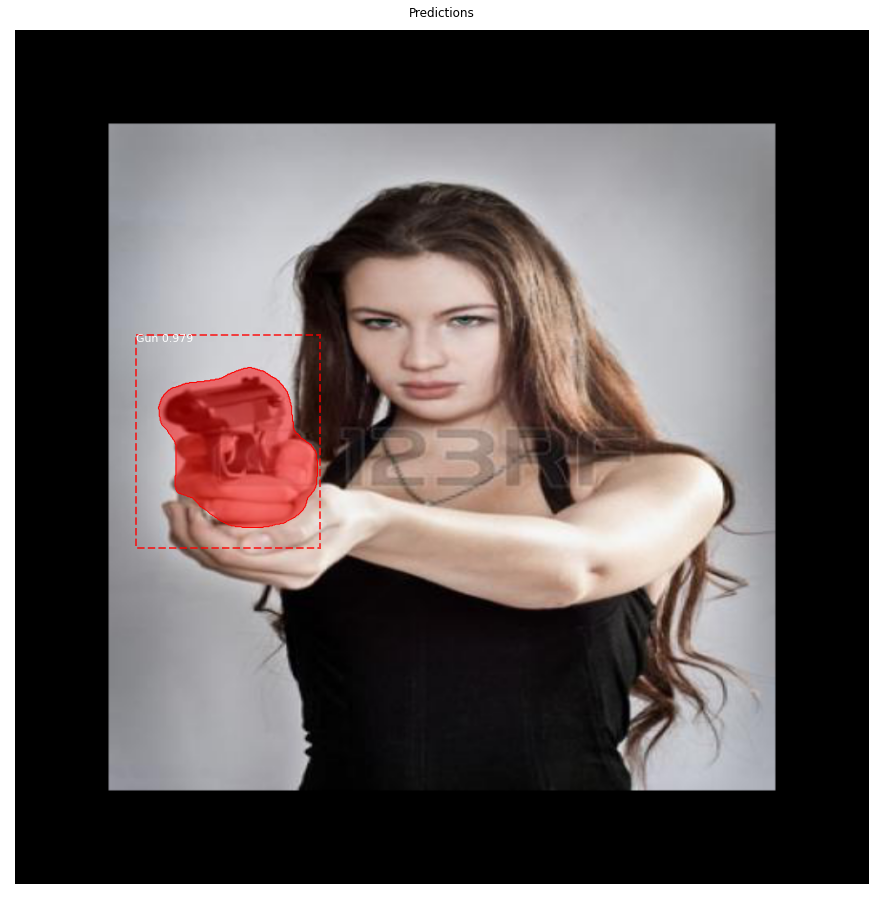

In [ ]:
#Ahora si podremos testear todo

#Corremos la detección
image_id = random.choice(dataset.image_ids)

#image_id = '/content/drive/MyDrive/RCNN_Gun/Dataset/prueba/descarga (3).jfif' #Les dejo como tarea como poder elegir de forma seleccionada la imagen que quieran
#Pero el truco no esta en al dirección en si, si no lo que llamamos ID o image_ids

print("image id is :",image_id)
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
info = dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id,dataset.image_reference(image_id)))
# Corremos el detector de objetos
results = model.detect([image], verbose=1)

# Imprimimos los resultados
x = get_ax(1)
r = results[0]
ax = plt.gca()
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], dataset.class_names, r['scores'], ax=ax, title="Predictions")
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

1
Processing 1 images
image                    shape: (720, 1280, 3)        min:    8.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1280.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


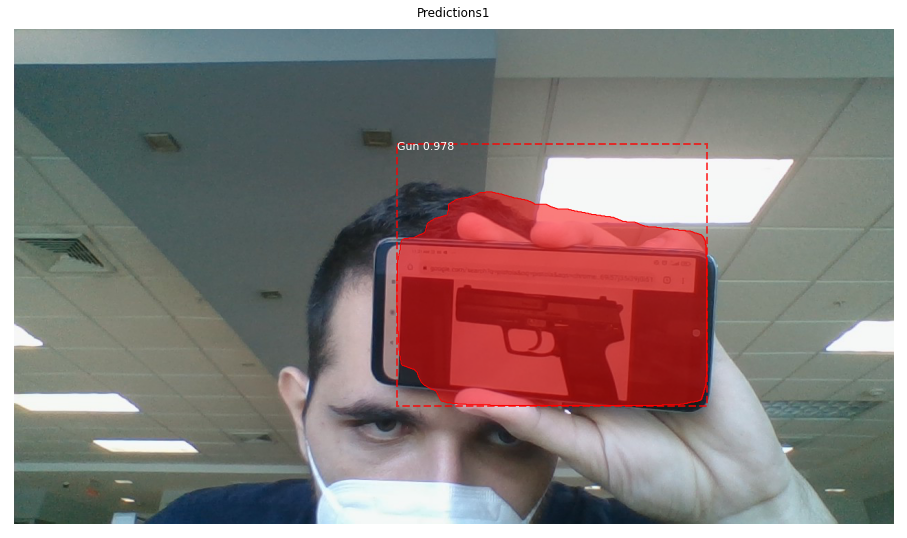

In [ ]:
# Este pedazo de codigo es para poder mostrar las imagenes que tu quieras, solo es cuestion de cambiar la ruta
path_to_new_image = '/content/drive/MyDrive/RCNN_Gun/Dataset/prueba/foto.jpg'
image1 = mpimg.imread(path_to_new_image)

# Se corre el detector
print(len([image1]))
results1 = model.detect([image1], verbose=1)

# Se muestran los resultados

ax = get_ax(1)
r1 = results1[0]
visualize.display_instances(image1, r1['rois'], r1['masks'], r1['class_ids'],
dataset.class_names, r1['scores'], ax=ax, title="Predictions1")

### Si haz llegado hasta aqui es porque te funciono, o no te sale e igual bajaste por todo el codigo buscando alguna respuesta, recuerda que este detector tiene muy pocas imagenes, como reto te invito a que puedas etiquetar y agregar mas imagenes al modelo para que no den tanta pena como la detección que este modelo da en algunos casos.

#Espero que te haya sido de ayuda